In [1]:
from utils import config
from utils.seq2seq import data

from utils.seq2seq.batcher import *

from utils.seq2seq.train_util import *
from utils.seq2seq.rl_util import *
from utils.seq2seq.initialize import loadCheckpoint, save_model
from utils.seq2seq.write_result import *
from datetime import datetime as dt
from tqdm import tqdm
from translate.seq2seq_beam import *
from tensorboardX import SummaryWriter
import argparse
from utils.seq2seq.rl_util import *
from torch.distributions import Categorical

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

parser = argparse.ArgumentParser()
parser.add_argument('--key_attention', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_encoder', type=bool, default=False, help = 'True/False')
parser.add_argument('--intra_decoder', type=bool, default=False, help = 'True/False')
parser.add_argument('--copy', type=bool, default=True, help = 'True/False') # for transformer

parser.add_argument('--model_type', type=str, default='seq2seq', choices=['seq2seq', 'transformer'])
parser.add_argument('--train_rl', type=bool, default=False, help = 'True/False')
parser.add_argument('--keywords', type=str, default='POS_keys', 
                    help = 'POS_keys / DEP_keys / Noun_adj_keys / TextRank_keys')

parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--rand_unif_init_mag', type=float, default=0.02)
parser.add_argument('--trunc_norm_init_std', type=float, default=0.001)
parser.add_argument('--mle_weight', type=float, default=1.0)
parser.add_argument('--gound_truth_prob', type=float, default=0.1)

parser.add_argument('--max_enc_steps', type=int, default=1000)
parser.add_argument('--max_dec_steps', type=int, default=50)
parser.add_argument('--min_dec_steps', type=int, default=8)
parser.add_argument('--max_epochs', type=int, default=10)
parser.add_argument('--vocab_size', type=int, default=50000)
parser.add_argument('--beam_size', type=int, default=16)
parser.add_argument('--batch_size', type=int, default=1)

parser.add_argument('--hidden_dim', type=int, default=512)
parser.add_argument('--emb_dim', type=int, default=300)
parser.add_argument('--gradient_accum', type=int, default=1)

parser.add_argument('--load_ckpt', type=str, default='0588000', help='0002000')
parser.add_argument('--word_emb_type', type=str, default='word2Vec', help='word2Vec/glove/FastText')
parser.add_argument('--pre_train_emb', type=bool, default=True, help = 'True/False') # 若pre_train_emb為false, 則emb type為NoPretrain


opt = parser.parse_args(args=[])
config = re_config(opt)
loggerName, writerPath = getName(config)   
logger = getLogger(loggerName)
print(loggerName)

# load_model_path = config.save_model_path + '/%s/%s.tar' % (loggerName, config.load_ckpt)

load_model_path = 'model/saved_models_old_main6Cat' + '/%s/%s.tar' % (loggerName, config.load_ckpt)
print(load_model_path)

I0515 00:35:22.115855 140399905920832 file_utils.py:35] PyTorch version 1.4.0 available.
2020-05-15 00:35:23 - Pointer_generator_word2Vec - INFO: - logger已啟動
I0515 00:35:23.205549 140399905920832 train_util.py:106] logger已啟動


Pointer_generator_word2Vec
model/saved_models_old_main6Cat/Pointer_generator_word2Vec/0588000.tar


In [2]:
vocab = Vocab(config.vocab_path, config.vocab_size)

# Prepare Seq2Seq Data

In [3]:
from utils.seq2seq.batcher import Example, Batch
import matplotlib.pyplot as plt

config.batch_size = 1
config.gound_truth_prob = 0.5
# config.gound_truth_prob = 1.0

# data = {'review':'cheaper amazon than online vet work dog has arthritis and liver problem will find out bloodwork has improve . vet strongly recommend this supplement . sadly human and milk thistle lot go na try that and compare blood work . but this product does seem make dog move better .',
#         'summary':'<s> but this product does seem to make my dog move better </s>',
#         config.keywords: "vet online supplement recommend"}

# data = {'review':'this rear derailleur was breeze install and work well use replace the now obsolete after year rough use . the price was excellent and together with shimano quality hard not pick . note might consider next model next time see make difference the cost difference absolute term not much .',
#         'summary':'<s> an inexpensive and good quality rear derailleur that does it is job well </s>',
#         config.keywords: " ".join(eval("['system', 'loosely', 'even', 'full']"))}

data = {'review':'this mongoose flat tire bike joke pretty easy assemble and gorgeous but catch tough the upper thigh area when you ride it . now been awhile since rode bike go take some get use too . never the less love this bike and make anyone look cool ride it .',
        'summary':'it is pretty easy to assemble and it is gorgeous but there is',
        config.keywords: "vet online supplement recommend",
       "percent_lcs": '40.0'}

ex = Example(config, vocab, data)
b = Batch([ex])

b.enc_pad_mask

enc_batch, enc_padding_mask, enc_lens, enc_batch_extend_vocab, extra_zeros, coverage, ct_e, enc_key_batch, enc_key_mask, enc_key_lens= \
                get_input_from_batch(b, config, batch_first = True)
dec_batch, dec_padding_mask, dec_lens, max_dec_len, target_batch = \
        get_output_from_batch(b, config, batch_first = True)

# plot_attention

In [4]:
def plot_attention(data, X_label=None, Y_label=None):
    '''
    Plot the attention model heatmap
    Args:
      data: attn_matrix with shape [ty, tx], cutted before 'PAD'
      X_label: list of size tx, encoder tags
      Y_label: list of size ty, decoder tags
    '''
    fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
    #   heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.9)
#     heatmap = ax.pcolor(data, cmap='viridis', alpha=0.9)
    heatmap = ax.pcolor(data, cmap='hot', alpha=0.9)
    plt.colorbar(heatmap)
  
  # Set axis labels
    if X_label != None and Y_label != None:
        X_label = [x_label for x_label in X_label]
        Y_label = [y_label for y_label in Y_label]

        xticks = range(0,len(X_label))
        ax.set_xticks(xticks, minor=False) # major ticks
        ax.set_xticklabels(X_label, minor = False, rotation=45)   # labels should be 'unicode'
        plt.xlabel('review words')
        
        yticks = range(0,len(Y_label))
        ax.set_yticks(yticks, minor=False)
        ax.set_yticklabels(Y_label, minor = False)   # labels should be 'unicode'
        plt.ylabel('Decode summary words')
        plt.title('Encoder Attention')

        ax.grid(True)

# Load Pointer-Generator Model

In [5]:
from seq2seq import Model
import torch.nn as nn
import torch as T
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

load_step = None
model = Model(pre_train_emb=config.pre_train_emb, 
              word_emb_type = config.word_emb_type, 
              vocab = vocab)

model = model.cuda()
optimizer = T.optim.Adam(model.parameters(), lr=config.lr)   
# optimizer = T.optim.Adagrad(model.parameters(),lr=config.lr, initial_accumulator_value=0.1)


if os.path.exists(load_model_path):
    model, optimizer, load_step = loadCheckpoint(logger, load_model_path, model, optimizer)
    
# model.eval()
decode = []
with T.autograd.no_grad():
    enc_batch_ = model.embeds(enc_batch)  # Get embeddings for encoder input    
    enc_key_batch = model.embeds(enc_key_batch)  # Get key embeddings for encoder input
    enc_out, enc_hidden = model.encoder(enc_batch_, enc_lens)

    s_t = (enc_hidden[0], enc_hidden[1])  # Decoder hidden states
    x_t = get_cuda(T.LongTensor(len(enc_out)).fill_(START))  # Input to the decoder
    prev_s = None  # Used for intra-decoder attention (section 2.2 in https://arxiv.org/pdf/1705.04304.pdf)
    sum_temporal_srcs = None  # Used for intra-temporal attention (section 2.1 in https://arxiv.org/pdf/1705.04304.pdf)
    weight = None
    for t in range(min(max_dec_len, config.max_dec_steps)):
        use_gound_truth = get_cuda((T.rand(len(enc_out)) > config.gound_truth_prob)).long()  # Probabilities indicating whether to use ground truth labels instead of previous decoded tokens
        x_t = use_gound_truth * dec_batch[:, t] + (1 - use_gound_truth) * x_t  # Select decoder input based on use_ground_truth probabilities
        x_t = model.embeds(x_t)  
        final_dist, s_t, ct_e, sum_temporal_srcs, prev_s, enc_attn, dec_attn = model.decoder(x_t, s_t, enc_out, enc_padding_mask,
                                                                                  ct_e, extra_zeros,
                                                                                  enc_batch_extend_vocab,
                                                                                  sum_temporal_srcs, prev_s, enc_key_batch, enc_key_mask)

#         x_t = T.multinomial(final_dist,1).squeeze()  # Sample words from final distribution which can be used as input in next time step

#         is_oov = (x_t >= config.vocab_size).long()  # Mask indicating whether sampled word is OOV
#         x_t = (1 - is_oov) * x_t.detach() + (is_oov) * UNKNOWN_TOKEN  # Replace OOVs with [UNK] token
        x_t = T.max(final_dist, dim=1)[1]  # Sample words from final distribution which can be used as input in next time step

        if t == 0: weight = enc_attn
        else: weight = T.cat((weight, enc_attn), 0)  
        decode.append(x_t.item())
    #     print(x_t, enc_attn.shape, dec_attn)   # tensor(737, device='cuda:0') torch.Size([1, 50]) None
        # x軸是tgt words
        # y軸是src words
    # print(weight.shape)
print(decode)

dec_words = [vocab.id2word(d) for d in decode]
dec_words = " ".join(dec_words) 
data['dec_words'] = dec_words
print('dec_words',dec_words)

I0515 00:35:26.585666 140399905920832 utils_any2vec.py:341] loading projection weights from ../Train-Data/Mix6_mainCat/Embedding/word2Vec/word2Vec.300d.txt
I0515 00:35:36.664665 140399905920832 utils_any2vec.py:405] loaded (49676, 300) matrix from ../Train-Data/Mix6_mainCat/Embedding/word2Vec/word2Vec.300d.txt


model/saved_models_old_main6Cat/Pointer_generator_word2Vec/0588000.tar


2020-05-15 00:35:41 - Pointer_generator_word2Vec - INFO: - Loaded model at model/saved_models_old_main6Cat/Pointer_generator_word2Vec/0588000.tar
I0515 00:35:41.025185 140399905920832 initialize.py:212] Loaded model at model/saved_models_old_main6Cat/Pointer_generator_word2Vec/0588000.tar
2020-05-15 00:35:41 - Pointer_generator_word2Vec - INFO: - Loaded model step = 588000, loss = 2.28, r_loss = 0.00 
I0515 00:35:41.026382 140399905920832 initialize.py:213] Loaded model step = 588000, loss = 2.28, r_loss = 0.00 


[171, 133, 171, 100, 127, 1069, 6, 2704, 14, 884, 1202, 241, 3, 3]
dec_words pretty is pretty easy to assemble and gorgeous but catch tough in [STOP] [STOP]


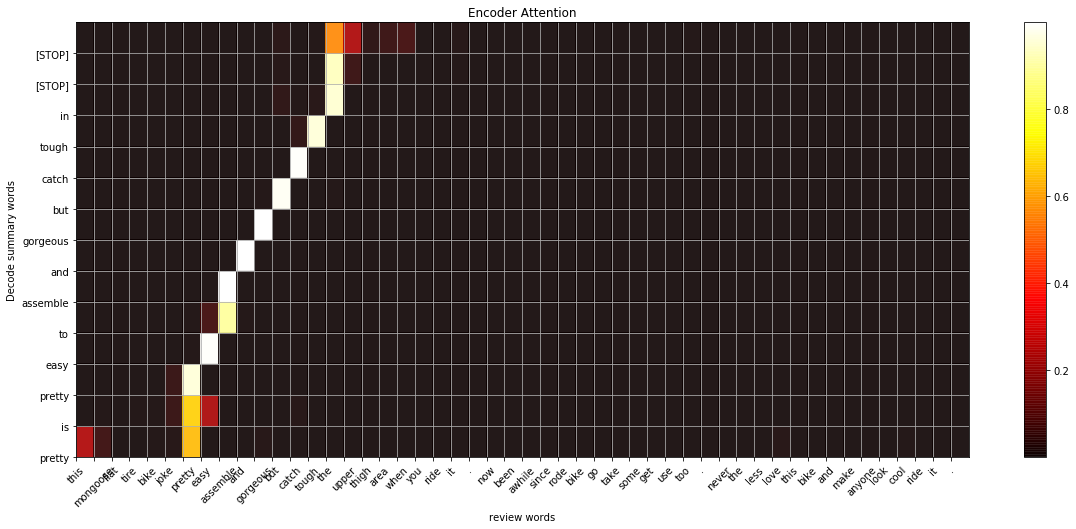

In [7]:
# plot_attention(weight.cpu().data, X_label=data['review'].split(), Y_label=data['summary'].split())
plot_attention(weight.cpu().data, X_label=data['review'].split(), Y_label=data['dec_words'].split())
# removeLogger(logger)